In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import AutoTokenizer
import pickle
import matplotlib.pyplot as plt
import sacrebleu
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_df = pd.read_csv('team11_bn_train.csv')
val_df = pd.read_csv('team11_bn_valid.csv')
test_df = pd.read_csv('team11_bn_test.csv')

train_df.columns = ['source', 'target']
val_df.columns = ['source', 'target']
test_df.columns = ['source', 'target']

In [ ]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format('glove.6B.100d.txt', binary=False, no_header=True)
glove_dim = glove.vector_size
indic_tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')


In [ ]:
all_target_sentences = list(train_df['target']) + list(val_df['target']) + list(test_df['target'])
all_tokens = set()
for sentence in all_target_sentences:
    tokens = indic_tokenizer.tokenize(sentence)
    all_tokens.update(tokens)

special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
token2idx = {token: idx + len(special_tokens) for idx, token in enumerate(sorted(all_tokens))}
for idx, token in enumerate(special_tokens):
    token2idx[token] = idx
idx2token = {v: k for k, v in token2idx.items()}

with open('token2idx.pkl', 'wb') as f:
    pickle.dump(token2idx, f)

In [ ]:
def encode_english_sentence(sentence, max_len=30):
    tokens = nltk.word_tokenize(sentence.lower())
    vectors = []
    for token in tokens:
        if token in glove:
            vectors.append(glove[token])
        else:
            vectors.append(np.random.normal(size=(glove_dim,)))
    if len(vectors) < max_len:
        vectors += [np.zeros(glove_dim)] * (max_len - len(vectors))
    else:
        vectors = vectors[:max_len]
    return np.array(vectors)

def encode_indic_sentence(sentence, max_len=30):
    tokens = indic_tokenizer.tokenize(sentence)
    indices = [token2idx.get('<sos>')] + [token2idx.get(token, token2idx['<unk>']) for token in tokens] + [token2idx.get('<eos>')]
    if len(indices) < max_len:
        indices += [token2idx.get('<pad>')] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, df):
        self.sources = df['source'].tolist()
        self.targets = df['target'].tolist()

    def __len__(self):
        return len(self.sources)

    def __getitem__(self, idx):
        source = encode_english_sentence(self.sources[idx])
        target = encode_indic_sentence(self.targets[idx])
        return torch.tensor(source, dtype=torch.float32), torch.tensor(target, dtype=torch.long)

train_dataset = TranslationDataset(train_df)
val_dataset = TranslationDataset(val_df)
test_dataset = TranslationDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)



In [ ]:
class TransformerMTModel(nn.Module):
    def __init__(self, tgt_vocab_size, embed_dim=100, num_heads=10, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=512, max_len=100):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_dim)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)

        self.output_layer = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_square_subsequent_mask(self, sz):
        # Generates causal mask for target to mask future tokens
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

    def forward(self, src, tgt):
        # src: [batch_size, src_len, embed_dim]
        # tgt: [batch_size, tgt_len]
        batch_size, src_len, _ = src.size()
        tgt_len = tgt.size(1)

        # Apply sinusoidal positional encoding
        src_pe = get_sinusoidal_positional_encoding(src_len, self.embed_dim, src.device)  # [src_len, embed_dim]
        tgt_pe = get_sinusoidal_positional_encoding(tgt_len, self.embed_dim, tgt.device)  # [tgt_len, embed_dim]

        # Add PE (broadcast over batch)
        src = src + src_pe.unsqueeze(0)  # [batch_size, src_len, embed_dim]
        tgt_emb = self.tgt_embedding(tgt) + tgt_pe.unsqueeze(0)  # [batch_size, tgt_len, embed_dim]

        # Transformer expects [seq_len, batch_size, embed_dim]
        src = src.permute(1, 0, 2)
        tgt_emb = tgt_emb.permute(1, 0, 2)

        memory = self.encoder(src)
        # Generate causal mask for decoder
        tgt_mask = self.generate_square_subsequent_mask(tgt_len).to(tgt.device)

        # Pass mask to decoder to mask future tokens
        output = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
        output = self.output_layer(output)
        return output.permute(1, 0, 2)

model = TransformerMTModel(tgt_vocab_size=len(token2idx)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=token2idx['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=1e-4)
from torch.amp import autocast, GradScaler
scaler = GradScaler()
epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for src, tgt in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        with autocast('cuda'):
            preds = model(src, tgt_input)
            preds = preds.reshape(-1, preds.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(preds, tgt_output)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            with autocast('cuda'):
                preds = model(src, tgt_input)
                preds = preds.reshape(-1, preds.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = criterion(preds, tgt_output)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")



In [ ]:
detok = TreebankWordDetokenizer()


def calculate_bleu_scores(model, dataloader, name="Test"):
    model.eval()
    all_references = []
    all_predictions = []
    examples = []

    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc=f"Evaluating {name}"):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]

            # Get predictions
            preds = model(src, tgt_input).argmax(-1)

            for pred_seq, true_seq in zip(preds, tgt):
                pred_tokens = []
                for idx in pred_seq:
                    token = idx2token.get(idx.item(), '<unk>')
                    if token == '<eos>':
                        break
                    if token != '<pad>':
                        pred_tokens.append(token)

                true_tokens = []
                for idx in true_seq:
                    token = idx2token.get(idx.item(), '<unk>')
                    if token in ['<pad>', '<sos>', '<eos>']:
                        continue
                    true_tokens.append(token)

                # Detokenize and replace underscores with spaces
                pred_sentence = detok.detokenize(pred_tokens).replace('▁', ' ').strip()
                true_sentence = detok.detokenize(true_tokens).replace('▁', ' ').strip()

                all_predictions.append(pred_sentence)
                all_references.append([true_sentence])
                examples.append((pred_sentence, true_sentence))

    bleu = sacrebleu.corpus_bleu(all_predictions, all_references)

    print(f"{name} Corpus BLEU score: {bleu.score:.2f}")
    print("BLEU-1:", bleu.precisions[0])
    print("BLEU-2:", bleu.precisions[1])
    print("BLEU-3:", bleu.precisions[2])
    print("BLEU-4:", bleu.precisions[3])

    print(f"\n{name} Sample Predictions:")
    for i in range(25):
        print(f"Source: {detok.detokenize(nltk.word_tokenize(dataloader.dataset.sources[i]))}")
        print(f"Target: {examples[i][1]}")
        print(f"Predicted: {examples[i][0]}\n")

    return bleu.score

In [ ]:
test_bleu = calculate_bleu_scores(model, test_loader, "Test")
val_bleu = calculate_bleu_scores(model, val_loader, "Validation")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

[nltk_data] Downloading package punkt to C:\Users\Ashwin
[nltk_data]     Kilingar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\Ashwin Kilingar\AppData\Local\Programs\python\python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training Epoch 1: 100%|██████████| 7000/7000 [08:38<00:00, 13.51it/s]


Epoch 1 Train Loss: 4.2008
Epoch 1 Val Loss: 3.4868


Training Epoch 2: 100%|██████████| 7000/7000 [07:16<00:00, 16.03it/s]


Epoch 2 Train Loss: 3.3398
Epoch 2 Val Loss: 3.0765


Training Epoch 3: 100%|██████████| 7000/7000 [08:43<00:00, 13.36it/s]


Epoch 3 Train Loss: 3.0232
Epoch 3 Val Loss: 2.8395


Training Epoch 4: 100%|██████████| 7000/7000 [10:24<00:00, 11.22it/s]


Epoch 4 Train Loss: 2.8211
Epoch 4 Val Loss: 2.6691


Training Epoch 5: 100%|██████████| 7000/7000 [08:35<00:00, 13.57it/s]


Epoch 5 Train Loss: 2.6791
Epoch 5 Val Loss: 2.5510


Training Epoch 6: 100%|██████████| 7000/7000 [08:17<00:00, 14.08it/s]


Epoch 6 Train Loss: 2.5691
Epoch 6 Val Loss: 2.4673


Training Epoch 7: 100%|██████████| 7000/7000 [08:07<00:00, 14.36it/s]


Epoch 7 Train Loss: 2.4855
Epoch 7 Val Loss: 2.4030


Training Epoch 8: 100%|██████████| 7000/7000 [07:58<00:00, 14.63it/s]


Epoch 8 Train Loss: 2.4190
Epoch 8 Val Loss: 2.3529


Training Epoch 9: 100%|██████████| 7000/7000 [08:04<00:00, 14.43it/s]


Epoch 9 Train Loss: 2.3609
Epoch 9 Val Loss: 2.3091


Training Epoch 10: 100%|██████████| 7000/7000 [07:57<00:00, 14.66it/s]


Epoch 10 Train Loss: 2.3118
Epoch 10 Val Loss: 2.2781


Evaluating Test: 100%|██████████| 1000/1000 [00:33<00:00, 30.00it/s]


Test Corpus BLEU score: 35.36
BLEU-1: 85.71428571428571
BLEU-2: 74.07407407407408
BLEU-3: 30.76923076923077
BLEU-4: 8.0

Test Sample Predictions:
Source: People ran out of their houses in panic despite severe cold condition.
Target: পর চ ণ ড  ঠ ণ ডর  ম ধ য ও  ঘর ব ড  ছ ড  রস ত য  বর য  আসন  ভ য রত  লক জন ।
Predicted: বর ণ ণ ড য ণ ড  ম ধ য । য ব য য ড য ত  ভ । ড । । ড ।  ভ ড য

Source: Trump in India
Target: ভরত  বত র ক  উস ক  দল ন  ট রম প
Predicted: ভরত ক র ক  দল ক  দল ন

Source: We got it.
Target: পল ম  আম র ।
Predicted: আম ম । র  পল

Source: Two juveniles were also apprehended.
Target: আটক  কর  হ য ছ   দই  নব লক  ছ তর ক ও ।
Predicted: কর  হ য ছ । দই  আটক লক  আটক তর ক  আটক  আটক

Source: Ministry of Panchayati Raj Local administrations at district and village levels continue taking various measures to check the spread of the COVID-19 pandemic in the country Measures include preliminary testing of local people creating checkposts for medical screening of persons entering and leaving the

Evaluating Validation: 100%|██████████| 2000/2000 [01:06<00:00, 30.17it/s]


Validation Corpus BLEU score: 0.00
BLEU-1: 100.0
BLEU-2: 0.0
BLEU-3: 0.0
BLEU-4: 0.0

Validation Sample Predictions:
Source: A Game of Thrones
Target: আ  গম  অব   থর নস
Predicted: থর

Source: BJP celebrates Narendra Modi's birthday
Target: next  ঘ ড   উড য  পর ধন মন তর  নর ন দর  মদ র  জনম দন  পল ন  করব  বজ প
Predicted: মদ র ণ

Source: Both the appeals were dismissed.
Target: দ ’ ট  আপ ল ই  খর জ  হ য  য য ।
Predicted: য ’ ট ই ল  দ  দ জ  দ য । য ।

Source: The police arrested Babloo later.
Target: এর  পরই  পল শ  বব লক  গ রফত র  কর ।
Predicted: এর  পরই  পল শ ।  পল  পল রফত র  কর  পল

Source: But he isnt worried.
Target: তব  তন  শ ঙ কম কত  ন য ।
Predicted: তব  শ । ঙ কত  ন  ন য ।

Source: So, we have taken the same dimension 3 centimetre 4 centimetre, x y are same, but now there are 2 feed 1 and 2 . So, you can actually see the response, this response is almost similar to the previous case here.
Target: সত র, আম র  একই  মত র ট  3  সম, 4  সন টম টর, এক স  ও য ই  সমন  গর হণ  করছ  তব  এখন  2
Pre

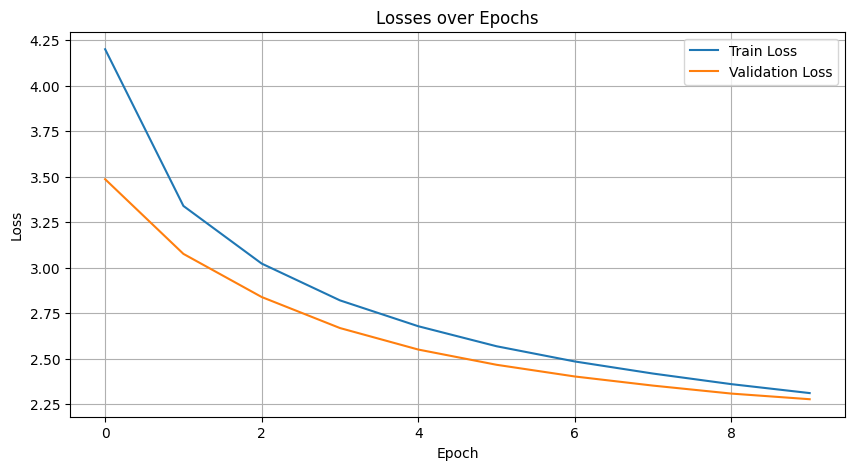

Model and training state saved to 'transformer_mt_checkpoint.pth'


In [ ]:
# Load model
checkpoint = torch.load('transformer_mt_checkpoint.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
